# Country Clustering with Python
## Background
The purpose of this notebook is to recreate a project which was initially written in `R` and completed by me, K.M.,and K.T. (if y'all ever come across this, you know who you are).  While feeling pretty comfortable with `R`, I want to practice using `Python` data analysis tools to get a better feel for them.  The dataset used is found on [Kaggle and was collected by HELP International](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data).
## Data Description
We have 167 countries reflected by 9 different socio-economic/health features:

| Variable | Description | Type     |
| :-------------: | :---------- | :-----------: |
|`country`|Name of country|`chr`|
|`child_mort`|Death of children under 5 years of age per 1000 live births|`dbl`|
|`exports`|Exports of goods and services per capita.  Given as %age of GDP per capita.|`dbl`|
|`health`|Total health spending per capita.  Given as %age of GDP per capita.|`dbl`|
|`imports`|Imports of goods and services per capita.  Given as %age of the GDP per capita|`dbl`|
|`income`|Net income per person|`int`|
|`inflation`|The measurement of the annual growth rate of the Total GDP|`dbl`|
|`life_expec`|The average number of years a new born child would live if the current mortality patters are to remain the same|`dbl`|
|`total_fer`|The number of children that would be born to each woman if the current age-fertility rates remain the same|`dbl`|
|`gdpp`|The GDP per capita.  Calculated as the Total GDP divided by the total population|`int`|

We will perform some **principal component analysis**, **k-means clustering**, and **hierarchical clustering** using scikit-learn and matplotlib.


### Imports

In [1]:
import numpy as np; np.random.seed(1337)
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt; plt.style.use('fivethirtyeight')
# %matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

### Here's the data we're working with

In [2]:
country_data = pd.read_csv('country-data.csv')
country_names = country_data.pop('country')
country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Confirming that we have no `NaN` values

In [3]:
nans=pd.DataFrame(country_data.isnull().sum()).T
nans.rename(index={0:'# NaN'}, inplace=True); nans

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
# NaN,0,0,0,0,0,0,0,0,0


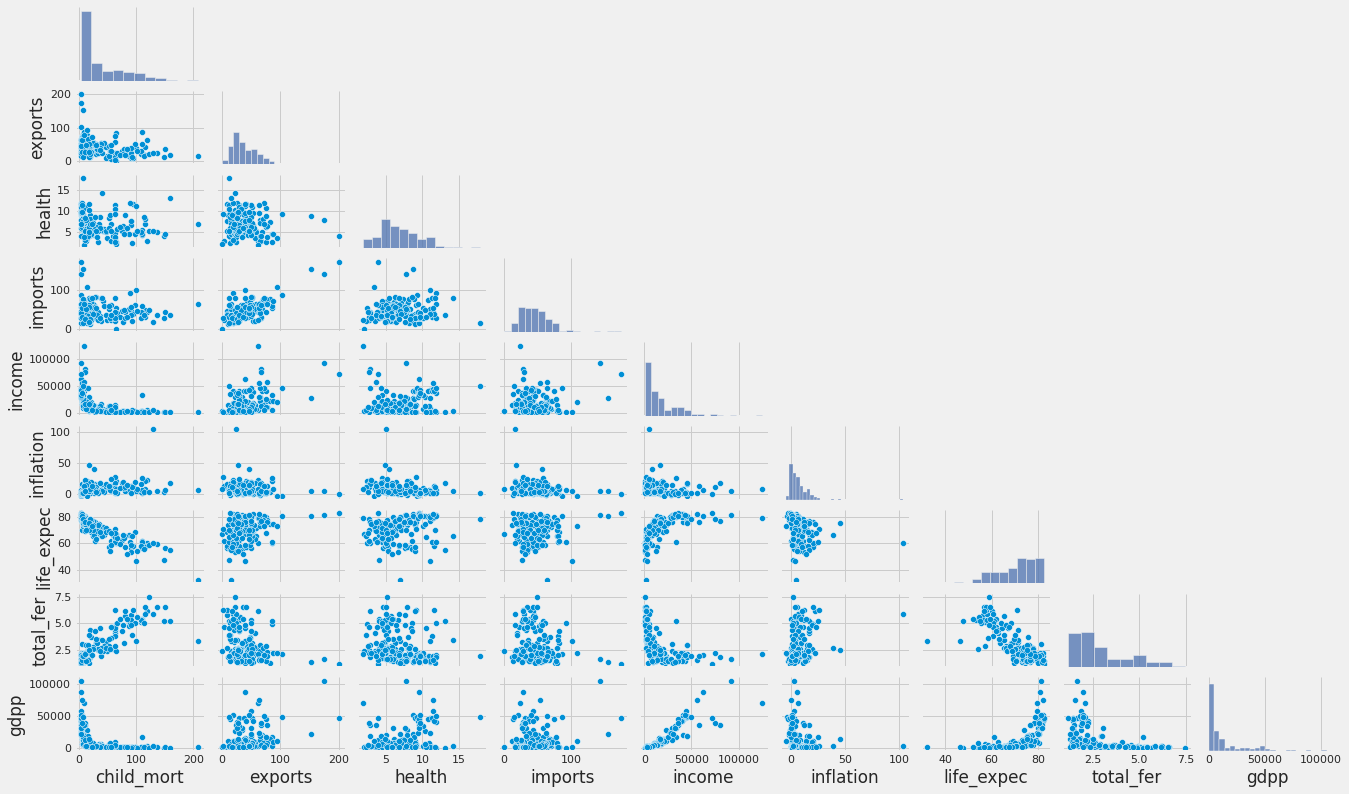

In [4]:
pairplot = sns.pairplot(country_data, corner=True, aspect=1.7, height=1.25);

### Summary Statistics
From an initial look, we see that some variables vary wildly.  Seems that income and GDP may cause problems if not scaled properly.  We also Have some outliers like the maximum for inflation or minimum for life expectancy.

In [5]:
country_data.describe()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Data before scaling:

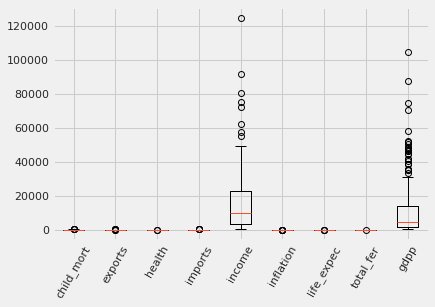

In [6]:
plt.boxplot(country_data, labels=country_data.columns)
plt.xticks(rotation=60);

### Data after scaling:

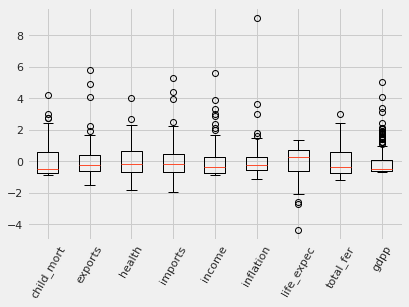

In [7]:
plt.boxplot(scale(country_data), labels=country_data.columns);
plt.xticks(rotation=60);

### Correlations

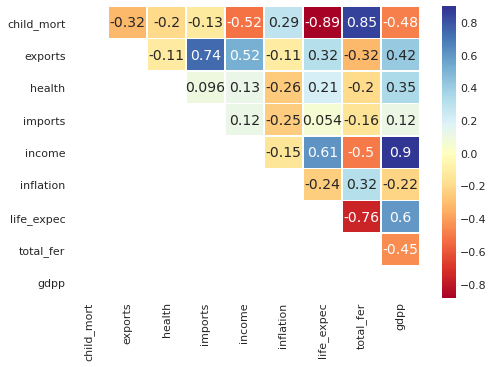

In [8]:
cor = country_data.corr()
mask = np.zeros_like(cor)
mask[np.tril_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cor, 
                cmap = 'RdYlBu',
                mask=mask, 
                center=0, annot=True, linewidths=.5)

### PCA
The first 3 components explain almost 80% of the variance.

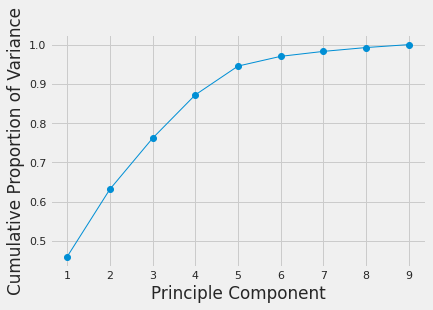

In [9]:
country_data_scaled = scale(country_data)
country_pca = PCA()
pca = country_pca.fit_transform(country_data_scaled)
plt.plot(np.arange(1,10), np.cumsum(country_pca.explained_variance_ratio_), 'o-', linewidth='1');
plt.xlabel('Principle Component');
plt.ylabel('Cumulative Proportion of Variance');

### K-means Clustering
An initial attempt at clustering.

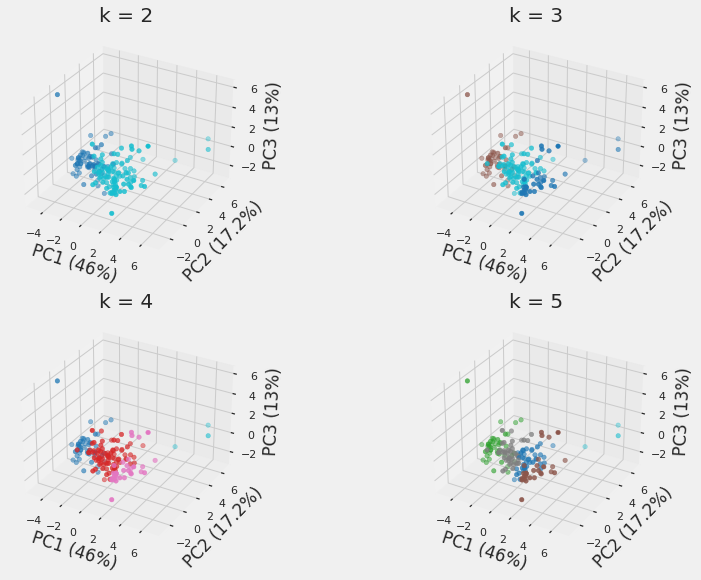

In [10]:
def pipeline(data, loc, fig, k=2):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    ax = fig.add_subplot(loc, projection='3d')
    ax.set_title('k = {}'.format(k))
    ax.scatter(pca[:,0], pca[:,1], pca[:,2],
        c=kmeans.labels_,
        cmap='tab10');
    ax.set_xlabel('PC1 (46%)');
    ax.set_ylabel('PC2 (17.2%)');
    ax.set_zlabel('PC3 (13%)');


fig = plt.figure(figsize=(12,9))
pipeline(country_data_scaled, 221, fig, k=2)
pipeline(country_data_scaled, 222, fig, k=3)
pipeline(country_data_scaled, 223, fig, k=4)
pipeline(country_data_scaled, 224, fig, k=5)

### Next, we'll measure different metrics to find the optimal number of clusters

In [11]:
# metric code here